In [2]:
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seawater as sw
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
import uuid
from scipy import interpolate
from scipy import signal
from glob import glob
from sklearn.linear_model import LinearRegression
from matplotlib import ticker, cm
import matplotlib.colors as colors
import datetime as dt
import scipy.ndimage

#create xarray dataset with saildrone filenames
#data directory for saildrone data
data_dir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/saildrone_usv_data/'
saildrone_filenames = [x for x in glob(data_dir+'saildrone*.nc')]

#data direcgtory for temperature logger .csv files
data_dir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/temp_log_proc/'
#adir_sbe='F:/data/cruise_data/saildrone/2020_atomic/temp_log_proc/'

#data direcgtory for temperature logger .csv files
figs_dir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/figs/'

#get list of all filenames in directory
logger_filenames = [x for x in glob(data_dir+'*1_min*.nc')]
#print('number of file:',len(files))
#print(files)

In [31]:
#subroutines for calculating PSD & making plot

def cal_psd(data_in):
    #calculate PSD for each USV
    data_all=[]
    for iusv in range(3):
        ds_usv = data_in.isel(trajectory=0)
        ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
        ds3 = ds2.swap_dims({'time':'dist_total'})
        dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
        ds4 = ds3.interp(dist_total=dist_interp)
        den = ds4.density_mean.interpolate_na(dim='dist_total')
        den = den.where(np.isfinite(den),drop=True)
        ds4_detrend = signal.detrend(den)
        ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
        freq, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
        if iusv==0:
            data_all=ds4_detrend_smooth
            ps_all=Pxx_den[0:10000]
        else:
            data_all = np.concatenate([data_all,ds4_detrend_smooth])
            ps_all = np.vstack([ps_all,Pxx_den[0:10000]])
            
    #make arrays for sampling at different length scales
    length_scale = np.arange(.1,100,1)
    # create the empty data arrays to store the normalized histograms (normalized the *100 for percentage count)
    xx_in = np.arange(0,.04,.001)
    xx_in2 = np.arange(0,.04-.001,.001)
    data = np.zeros((len(length_scale),len(xx_in2)))
    ddn=xr.DataArray(data,dims=('length_scale','gradx'),coords={'length_scale':length_scale,'gradx':xx_in2})
    for iusv in range(3):
        ds_usv = data_in.isel(trajectory=iusv)
        ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
        ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
        for ilen2,len2 in enumerate(length_scale):
            dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
            ds4 = ds3.interp(dist_total=dist_interp)       
            den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
            result,xx = np.histogram(den_grad,bins=xx_in)
            ddn[ilen2,:]=ddn[ilen2,:]+result
    for ilen2,len2 in enumerate(length_scale):
        ddn[ilen2,:]=ddn[ilen2,:]/sum(ddn[ilen2,:])*100  #normalize & turn into percent

    return freq,ps_all,Pxx_den,ddn


def psd_fig(f,data_in,psd_in,text1,fout):
   
    length_scale = np.arange(.1,100,1)
    xx_in = np.arange(0,.04,.001)
    xx_in2 = np.arange(0,.04-.001,.001)
    print(len(length_scale),len(xx_in))
    fig = plt.figure(figsize=(14,10))
    tem=data_in
    tem = tem.where(tem>.003)
    Z=tem.T
    ax = plt.pcolormesh(length_scale,xx_in2,Z, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),vmin=.01,vmax=100,cmap='hot')
    plt.text(25,0.036,'(a)'+text1,fontsize=16,color='k')
    plt.xlabel('Length scale (km)',fontsize=16)
    plt.ylabel('Density gradient (kg m$^{-3}$ km$^{-1}$)',fontsize=16)
    cb = plt.colorbar()
    cb.set_label(label='Percent count',fontsize=16)

    plt.axes([.43, .57, .3, .3])

    #cal PSD
    Pxx_den = np.mean(psd_in,axis=0)
    #f, Pxx_den = signal.periodogram(Pxx_den,1/.080)  #fs = sampled at .08km or 80m
    istart,iend=10,5550
    plt.loglog(f[istart:iend], Pxx_den[istart:iend])

    #linear regression to PSD
    istart,iend=10,1000
    XX = np.log(f[istart:iend])
    YY = np.log(Pxx_den[istart:iend])
    reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
    a = float(reg.coef_)
    b = -1*float(reg.intercept_)
    plt.loglog(f[istart:iend], f[istart:iend]**(a)/np.exp(b),'r') #test from fit
    slp_str = 'slope = '+"{:.1f}".format(a)
    plt.text(.02,10,slp_str,fontsize=16,color='r')
    plt.ylim([10e-6,10e1])
    plt.xlim([10e-4,10e-1])

    plt.text(.001,20,'(b)',fontsize=16,color='k')
    plt.xlabel('Wavenumber (cpkm)')
    plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$]')
    plt.grid()
    plt.savefig(figs_dir+fout)
    return


# Read in USV data for all 3 Saildrone
- caluclate density and wind speed
- caluclate distance between successive obs
- caluculate total cumulative distance
- switch from time to cumulative distance as index
- interpolate data onto grid


In [4]:

ds=[]
for iusv in range(3):
    fname=saildrone_filenames[iusv]
    ds_usv=xr.open_dataset(fname).isel(trajectory=0).swap_dims({'obs':'time'})
    ds_usv.close()
    ds_usv['wspd']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)   
    tem=sw.dens0(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN)
    ds_usv['density_mean']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.alpha(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['alpha_ME']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.beta(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['beta_MEAN']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['latitude']=ds_usv.latitude.interpolate_na(dim='time')
    ds_usv['longitude']=ds_usv.longitude.interpolate_na(dim='time')
    xlat=ds_usv.latitude
    xlon=ds_usv.longitude
    dkm2 = abs(np.abs((((xlon[1:].data-xlon[0:-1].data)**2+(xlat[1:].data-xlat[0:-1].data)**2)**.5)*110.567*np.cos(np.pi*xlat[1:].data/180)))
    dkm2=np.append(dkm2,dkm2[66238]) #add on last point
    dkm3 = dkm2.cumsum()
    ds_usv['dist_total']=xr.DataArray(dkm3,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['dist_between']=xr.DataArray(dkm2,dims=('time'),coords={'time':ds_usv.time})
    if iusv==0:
        ds = ds_usv
    else:
        ds = xr.concat([ds,ds_usv],dim='trajectory')

# print out difference between two salinity sensors

In [5]:
# SBE37 minus RBR
dd=[]
for iusv in range(3):
    ds_usv=ds.isel(trajectory=iusv)
    dif = ds_usv.SAL_SBE37_MEAN-ds_usv.SAL_RBR_MEAN
    difm = dif.mean().data
    difs = dif.std().data
    print(iusv,"{:.2f}".format(difm),"{:.2f}".format(difs),np.isfinite(dif).sum().data)
    if iusv==0:
        dd=ds_usv.SAL_SBE37_MEAN.data
    else:
        dd = np.concatenate([dd,ds_usv.SAL_SBE37_MEAN.data])
print("{:.2f}".format(np.nanmean(dd)),"{:.2f}".format(np.nanstd(dd)),np.isfinite(dd).sum())
    

0 0.05 0.00 66183
1 0.06 0.01 66183
2 0.06 0.01 66183
35.87 0.60 198549


100 40


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


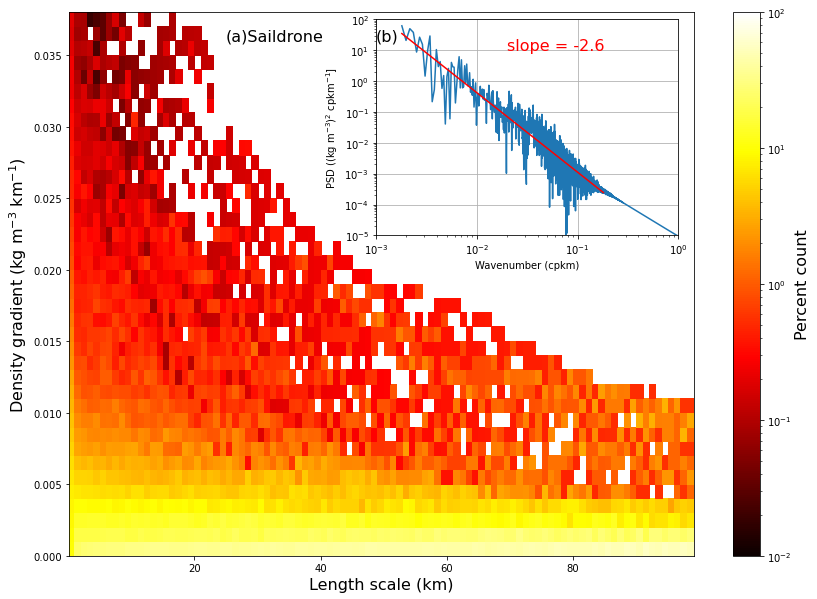

In [6]:
#call PSD figure Saildrones
freq,ps_all,Pxx_den,ddn = cal_psd(ds)
psd_fig(freq,ddn,ps_all,'Saildrone','PSD_den_grad.png')


# read in satellite data

In [7]:
t1,t2=dt.datetime(2020,1,17),dt.datetime(2020,3,7)
fnames=[]
for i in range(46):
    t=t1+dt.timedelta(days=i)
    tdir = t-dt.timedelta(days=4)
    sdoy = str(tdir.timetuple().tm_yday).zfill(3)
    smon = str(t.month).zfill(2)
    sdy  = str(t.day).zfill(2)
    fname = 'Z:/SalinityDensity/smap/L3/JPL/V4.3/8day_running/2020/' + sdoy + '/SMAP_L3_SSS_2020'+smon+sdy+'_8DAYS_V4.3.nc'
    fnames.append(fname)
tem = xr.open_mfdataset(fnames,combine='nested',concat_dim='time')
tem = tem.rename({'latitude':'lat','longitude':'lon'}).sel(lon=slice(-64,-46),lat=slice(16,4))
ds_jpl = tem.load()

In [8]:
t1,t2=dt.datetime(2020,1,17),dt.datetime(2020,3,7)
fnames=[]
for i in range(46):
    t=t1+dt.timedelta(days=i)
    tdir = t-dt.timedelta(days=4)
    sdoy = str(tdir.timetuple().tm_yday).zfill(3)
    sdoy2 = str(t.timetuple().tm_yday).zfill(3)
    fname = 'F:/data/sat_data/smap/SSS/L3/RSS/V4/8day_running/SCI/2020/' + sdoy + '/RSS_smap_SSS_L3_8day_running_2020_'+sdoy2+'_FNL_v04.0.nc'
#    fname = 'Z:/SalinityDensity/smap/L3/RSS/V4/8day_running/SCI/2020/' + sdoy + '/RSS_smap_SSS_L3_8day_running_2020_'+sdoy2+'_FNL_v04.0.nc'
    fnames.append(fname)
tem = xr.open_mfdataset(fnames,combine='nested',concat_dim='time')
tem.coords['lon'] = (tem.coords['lon'] + 180) % 360 - 180
tem = tem.sortby(tem.lon)
tem = tem.sel(lon=slice(-64,-46),lat=slice(4,16))
ds_rss = tem.load()

# Make map

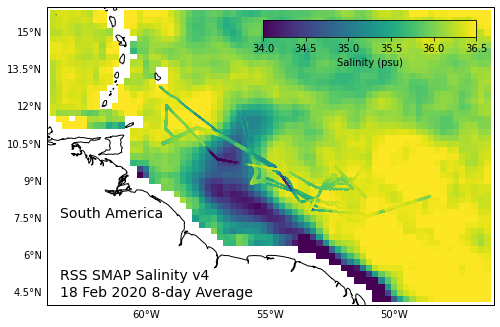

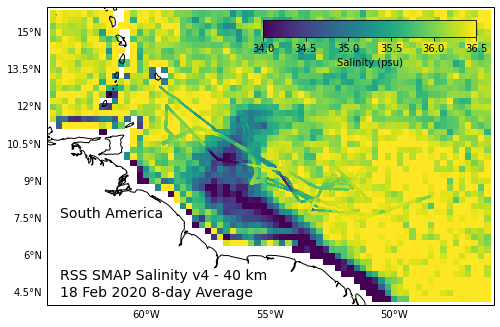

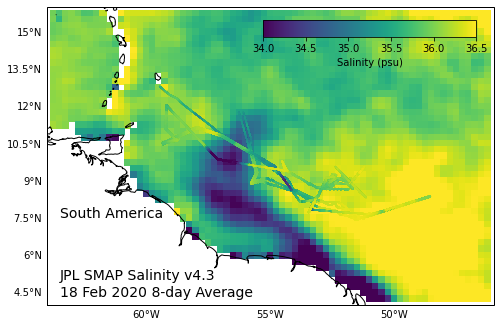

In [9]:
def map_fig(ds_sat,var,text1,text2,fout):
    fig = plt.figure(figsize=(8,12))
    ax = plt.axes(projection = ccrs.PlateCarree())  # create a set of axes with Mercator projection
    im=ax.pcolormesh(ds_sat.lon,ds_sat.lat,ds_sat[var],vmin=34,vmax=36.5,transform=ccrs.PlateCarree(),cmap='viridis')
    for i in range(3):
        ds2 = ds.isel(trajectory=i)
        ax.scatter(ds2.longitude,ds2.latitude,c=ds2.SAL_SBE37_MEAN,vmin=34,vmax=36.5,
                      s=.15,transform=ccrs.PlateCarree(),label=ds2.trajectory.data,cmap='viridis')

    ax.coastlines(resolution='10m')                
    ax.set_extent([-64,-46,4,16])
    bx1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0, color='grey', alpha=0.5, linestyle='--')
    bx1.xlabels_top = False; bx1.ylabels_left = True
    bx1.ylabels_right = False; bx1.xlines = False
    bx1.xlocator = mticker.FixedLocator([-60,-55,-50,-45])
    bx1.xformatter = LONGITUDE_FORMATTER; bx1.yformatter = LATITUDE_FORMATTER

    #ax.legend()
    ax.text(-63.5,7.5,'South America',fontsize=14)
    ax.text(-63.5,5,text1,fontsize=14)
    ax.text(-63.5,4.3,text2,fontsize=14)
    cax = fig.add_axes([0.5, 0.64, 0.37, 0.02])
    cbar = fig.colorbar(im,cax=cax, orientation='horizontal')
    cbar.set_label('Salinity (psu)')
    fig.savefig(figs_dir+fout)     

text1='RSS SMAP Salinity v4'
text2='18 Feb 2020 8-day Average'
map_fig(ds_rss.sel(time='2020-02-18T12'),'sss_smap',text1,text2,'map_sss_rss_smap.png')

text1='RSS SMAP Salinity v4 - 40 km'
text2='18 Feb 2020 8-day Average'
map_fig(ds_rss.sel(time='2020-02-18T12'),'sss_smap_40km',text1,text2,'map_sss_rss_smap40km.png')

text1='JPL SMAP Salinity v4.3'
text2='18 Feb 2020 8-day Average'
map_fig(ds_jpl.sel(time='2020-02-18T12'),'smap_sss',text1,text2,'map_sss_jpl_smap.png')

# print stats

In [45]:
ds_rss

<xarray.Dataset>
Dimensions:               (lat: 48, lon: 72, time: 46)
Coordinates:
  * lon                   (lon) float32 -63.875 -63.625 ... -46.375 -46.125
  * lat                   (lat) float32 4.125 4.375 4.625 ... 15.625 15.875
  * time                  (time) datetime64[ns] 2020-01-17T12:00:00 ... 2020-03-02T12:00:00
Data variables:
    nobs                  (time, lat, lon) float64 nan nan nan ... 9.0 9.0 9.0
    nobs_40km             (time, lat, lon) float64 nan nan nan ... 10.0 9.0 9.0
    sss_smap              (time, lat, lon) float32 nan nan ... 36.999664
    sss_smap_uncertainty  (time, lat, lon) float32 nan nan ... 0.22324671
    sss_smap_40km         (time, lat, lon) float32 nan nan ... 37.30617 37.15341
    sss_ref               (time, lat, lon) float32 nan nan ... 36.494976 36.5338
    gland                 (time, lat, lon) float32 0.9989253 ... 0.00010701262
    fland                 (time, lat, lon) float32 1.0 1.0 ... 1.2631062e-08
    gice                  (time, lat, lon) float32 nan nan nan ... 0.0 0.0 0.0
    surtep                (time, lat, lon) float32 nan nan ... 297.9527
Attributes:
    Conventions:                                    CF-1.6, ACDD-1.3
    standard_name_vocabulary:                       CF Standard Name Table v27
    title:                                          SMAP ocean surface salinity
    version:                                        V4.0 Validated Release
    processing_level:                               L3
    resolution:                                     Spatial resolution: appro...
    history:                                        created by T. Meissner
    date_created:                                   2020-01-26 T10:30:21-0800
    date_modified:                                  2020-01-26 T10:30:21-0800
    institution:                                    Remote Sensing Systems, S...
    source:                                         RSS SMAP-SSS v4.0 algorithm
    platform:                                       SMAP
    instrument:                                     SMAP radiometer
    project:                                        NASA Salinity
    keywords:                                       SURFACE SALINITY, SALINIT...
    keywords_vocabulary:                            NASA Global Change Master...
    creator_name:                                   Thomas Meissner, Remote S...
    creator_email:                                  meissner@remss.com
    creator_url:                                    http://www.remss.com/miss...
    publisher_name:                                 Thomas Meissner, Frank We...
    publisher_email:                                meissner@remss.com
    publisher_url:                                  http://www.remss.com/miss...
    ID:                                             10.5067/SMP40-3SPCS
    naming_authority:                               gov.nasa.earthdata
    dataset_citation_authors:                       T. Meissner, F. Wentz, A....
    dataset_citation_year:                          2019
    dataset_citation_product:                       Remote Sensing Systems SM...
    dataset_citation_version:                       V4.0 Validated Release
    dataset_citation_institution:                   Remote Sensing Systems, S...
    dataset_citation_url:                           Available online at www.r...
    netCDF_version_id:                              4
    year_of_observation:                            2020
    center_day_of_observation:                      17
    first_orbit:                                    26442
    last_orbit:                                     26557
    time_coverage_start:                            2020-01-13T12:00:00Z
    time_coverage_end:                              2020-01-21T12:00:00Z
    time_coverage_resolution:                       P8D
    cdm_data_type:                                  grid
    geospatial_lat_min:                             -90.0
    geospatial_lat_m

In [64]:
def print_stats(tstr,ds_sat2,var,ds_in,varsst,varden):
    import xarray
    import seawater as sw
    print('******'+tstr+'*******')
    for iusv in range(3):
        ds_usv = ds_in.isel(trajectory=iusv)
        tem = ds_sat2.interp(time=ds_usv.time,lat=ds_usv.latitude,lon=ds_usv.longitude)
        dif = tem[var]-ds_usv.SAL_SBE37_MEAN
        difm = dif.mean().data
        difs = dif.std().data
        print(iusv,"{:.2f}".format(difm),"{:.2f}".format(difs),np.isfinite(dif).sum().data)
        tem2=sw.dens0(tem[var],tem[varsst]-273.15) #ds.TEMP_SBE37_MEAN[iusv,:])
        tem[varden]=xr.DataArray(tem2.data,dims=('time'),coords={'time':ds_usv.time})
        tem['dist_total']=xr.DataArray(ds_usv.dist_total.data,dims=('time'),coords={'time':ds_usv.time})
        if iusv==0:
            ds_out = tem
        else:
            ds_out = xr.concat([ds_out,tem],dim='trajectory')
    return ds_out

ds_rss_usv = print_stats('RSS',ds_rss,'sss_smap',ds,'surtep','density_mean')
ds_rss_usv40 = print_stats('RSS40km',ds_rss,'sss_smap_40km',ds,'surtep','density_mean')
ds_jpl_usv = print_stats('JPL',ds_jpl,'smap_sss',ds,'anc_sst','density_mean')


******RSS*******
0 0.27 0.26 64744
1 0.28 0.26 64744
2 0.27 0.25 64744
******RSS40km*******
0 0.27 0.26 64744
1 0.28 0.27 64744
2 0.26 0.26 64744
******JPL*******
0 0.16 0.24 64744
1 0.16 0.25 64744
2 0.16 0.23 64744


# print eddy TS

3567.339265632886 4276.974209229797
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
[0.    0.166 0.332 0.498 0.664 0.83  0.996]


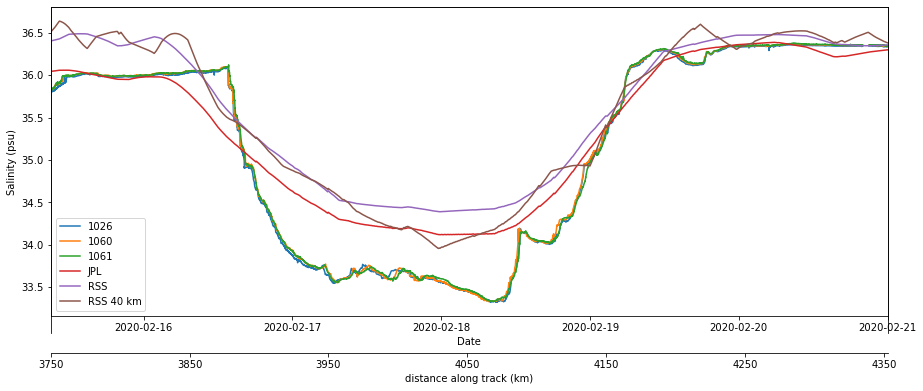

In [11]:
iusv=0
ds_usv = ds.isel(trajectory=iusv).sel(time=slice('2020-02-15T09','2020-02-21T0029'))
print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
ll=[]
for i in range(3750,4450,100):
    ll.append("{:.0f}".format(i))
print(ll)
fig,(ax0)= plt.subplots(1,1,figsize=(15,6))
t1,t2='2020-02-15T09','2020-02-21T00'
for iusv in range(3):
    ds_usv = ds.isel(trajectory=iusv).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv.SAL_SBE37_MEAN,label=ds_usv.trajectory.data)
ds_usv = ds_jpl_usv.isel(trajectory=0).sel(time=slice(t1,t2))
ax0.plot(ds_usv.time,ds_usv.smap_sss,label='JPL')
ds_usv = ds_rss_usv.isel(trajectory=0).sel(time=slice(t1,t2))
ax0.plot(ds_usv.time,ds_usv.sss_smap,label='RSS')
ax0.plot(ds_usv.time,ds_usv.sss_smap_40km,label='RSS 40 km')
ax0.legend()
ax0.set_ylabel('Salinity (psu)')
ax0.set_xlabel('Date')
ax0.set_xlim([np.datetime64(t1),np.datetime64(t2)])

pos = ax0.get_position()
pos.y0 = pos.y0+.04       # for example 0.2, choose your value
ax0.set_position(pos)
#handles, labels = ax.get_legend_handles_labels()
#ax0.get_xticklabels(), ha="right", rotation=45)
ax2 = ax0.twiny()
# Add some extra space for the second axis at the bottom
#fig.subplots_adjust(bottom=0.2)
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.06))
ax1Ticks = ax0.get_xticks()   
ax2Ticks = ax1Ticks
new_tick_locations = np.arange(0,1,0.166)
print(new_tick_locations)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(ll)
ax2.set_xlabel('distance along track (km)')
#labels = [item.get_text() for item in ax0.get_xticklabels()]
#ax0.set_xticklabels(labels,rotation=45) 
plt.savefig(figs_dir+'timeseries_eddy.png')
    

100 40


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


100 40


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


100 40


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


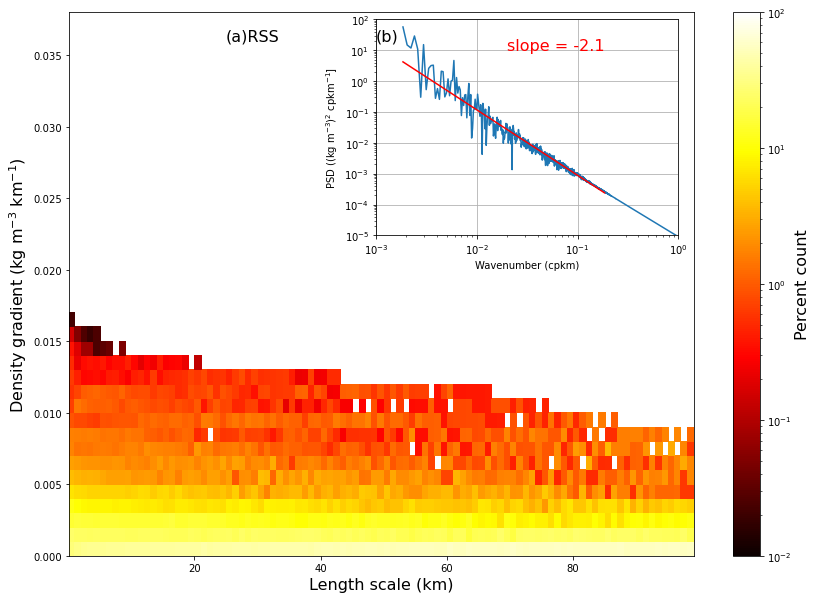

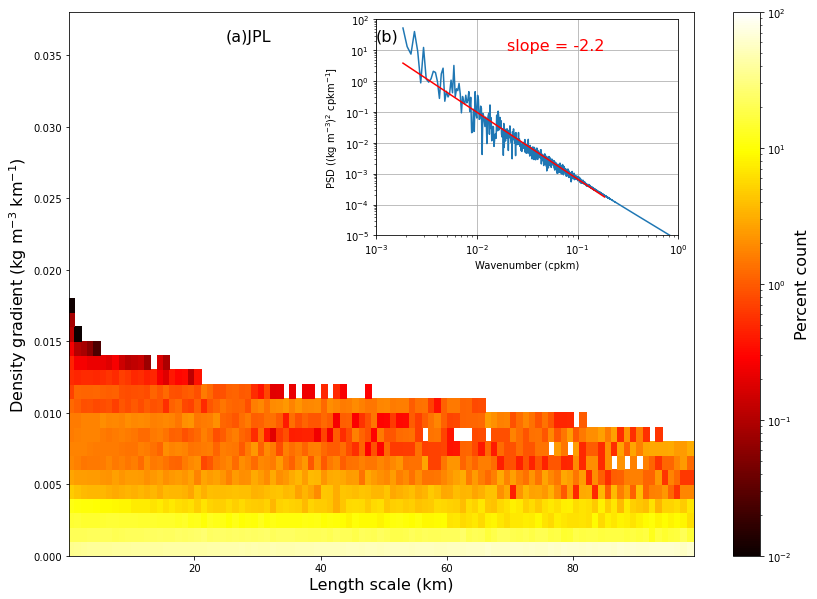

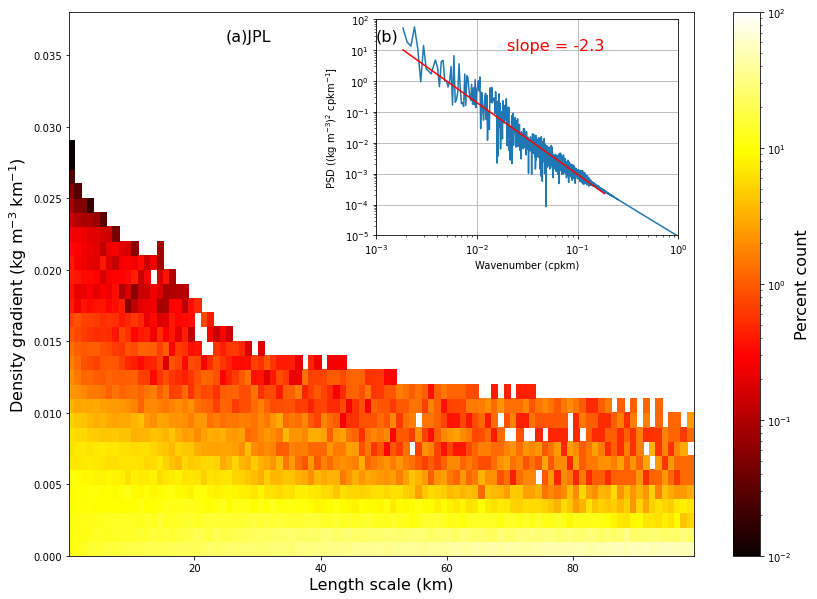

In [66]:
#make satellite spectrums / density plots
freq,ps_all,Pxx_den,ddn = cal_psd(ds_jpl_usv)
psd_fig(freq,ddn,ps_all,'RSS','PSD_den_grad_rss.png')
freq,ps_all,Pxx_den,ddn = cal_psd(ds_rss_usv)
psd_fig(freq,ddn,ps_all,'JPL','PSD_den_grad_rss.png')
freq,ps_all,Pxx_den,ddn = cal_psd(ds_rss_usv40)
psd_fig(freq,ddn,ps_all,'JPL','PSD_den_grad_rss_40km.png')


In [59]:
ds

<xarray.Dataset>
Dimensions:                         (time: 66240, trajectory: 3)
Coordinates:
  * time                            (time) datetime64[ns] 2020-01-17 ... 2020-03-02T23:59:00
    latitude                        (trajectory, time) float64 11.77 ... 9.193
    longitude                       (trajectory, time) float64 -56.28 ... -52.02
  * trajectory                      (trajectory) object '1026' '1060' '1061'
Data variables:
    SOG                             (trajectory, time) float64 2.214 ... 1.587
    SOG_FILTERED_MEAN               (trajectory, time) float64 1.894 ... 1.678
    SOG_FILTERED_STDDEV             (trajectory, time) float64 0.251 ... 0.299
    SOG_FILTERED_MAX                (trajectory, time) float64 2.597 ... 2.539
    SOG_FILTERED_MIN                (trajectory, time) float64 1.465 ... 1.027
    COG                             (trajectory, time) float64 153.7 ... 318.1
    COG_FILTERED_MEAN               (trajectory, time) float64 160.0 ... 318.8
    COG_FILTERED_STDDEV             (trajectory, time) float64 12.3 ... 14.1
    HDG                             (trajectory, time) float64 152.0 ... 311.9
    HDG_FILTERED_MEAN               (trajectory, time) float64 148.3 ... 310.2
    HDG_FILTERED_STDDEV             (trajectory, time) float64 0.0 0.0 ... 0.0
    ROLL_FILTERED_MEAN              (trajectory, time) float64 11.9 -2.8 ... 2.9
    ROLL_FILTERED_STDDEV            (trajectory, time) float64 0.0 0.0 ... 0.0
    ROLL_FILTERED_PEAK              (trajectory, time) float64 11.9 -2.8 ... 2.9
    PITCH_FILTERED_MEAN             (trajectory, time) float64 9.3 -1.0 ... -3.2
    PITCH_FILTERED_STDDEV           (trajectory, time) float64 0.0 0.0 ... 0.0
    PITCH_FILTERED_PEAK             (trajectory, time) float64 9.3 -1.0 ... -3.2
    HDG_WING                        (trajectory, time) float64 103.3 ... 51.7
    WING_HDG_FILTERED_MEAN          (trajectory, time) float64 99.6 ... 52.5
    WING_HDG_FILTERED_STDDEV        (trajectory, time) float64 3.8 4.7 ... 4.5
    WING_ROLL_FILTERED_MEAN         (trajectory, time) float64 3.3 3.6 ... 0.0
    WING_ROLL_FILTERED_STDDEV       (trajectory, time) float64 3.4 4.8 ... 3.1
    WING_ROLL_FILTERED_PEAK         (trajectory, time) float64 nan nan ... nan
    WING_PITCH_FILTERED_MEAN        (trajectory, time) float64 3.7 3.7 ... 1.0
    WING_PITCH_FILTERED_STDDEV      (trajectory, time) float64 5.3 4.4 ... 6.9
    WING_PITCH_FILTERED_PEAK        (trajectory, time) float64 15.8 ... 19.5
    WING_ANGLE                      (trajectory, time) float64 -48.8 ... 99.9
    UWND_MEAN                       (trajectory, time) float64 -8.51 ... -7.47
    UWND_STDDEV                     (trajectory, time) float64 0.61 0.6 ... 0.51
    VWND_MEAN                       (trajectory, time) float64 -1.83 ... -1.53
    VWND_STDDEV                     (trajectory, time) float64 0.59 ... 0.48
    WWND_MEAN                       (trajectory, time) float64 -0.1 ... -0.12
    WWND_STDDEV                     (trajectory, time) float64 0.32 ... 0.33
    GUST_WND_MEAN                   (trajectory, time) float64 9.7 8.82 ... 8.36
    GUST_WND_STDDEV                 (trajectory, time) float64 0.5 0.48 ... 0.36
    WIND_MEASUREMENT_HEIGHT_MEAN    (trajectory, time) float64 4.947 ... 4.946
    WIND_MEASUREMENT_HEIGHT_STDDEV  (trajectory, time) float64 0.059 ... 0.06
    TEMP_AIR_MEAN                   (trajectory, time) float64 26.98 ... 26.12
    TEMP_AIR_STDDEV                 (trajectory, time) float64 0.03 ... 0.04
    RH_MEAN                         (trajectory, time) float64 79.77 ... 78.45
    RH_STDDEV                       (trajectory, time) float64 0.49 ... 0.46
    BARO_PRES_MEAN                  (trajectory, time) float64 1.016e+03 ... 1.014e+03
    BARO_PRES_STDDEV                (trajectory, time) float64 0.06 ... 0.06
    PAR_AIR_MEAN                    (trajectory, time) float64 0.0 0.0 ... 0.0
    PAR_AIR_STDDEV                  (trajectory, time) float64 0.0 0.0 ... 0.0
  

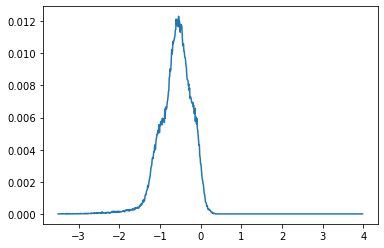

In [94]:
hist air sea temp diff
for iusv in range(3):
    ds_usv = ds.isel(trajectory=iusv)
    dif = ds_usv.TEMP_AIR_MEAN-ds_usv.TEMP_SBE37_MEAN
    hist, bin_edges = np.histogram(dif,bins=np.arange(-3.5,4,0.01))
    if iusv==0:
        hist2 = hist
    else:
        hist2+=hist
hist2=hist2/sum(hist2)
plt.plot(bin_edges[:-1],hist2)

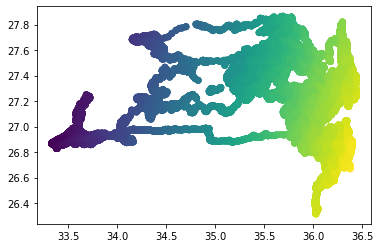

In [96]:
for iusv in range(3):
    plt.scatter(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,c=ds_usv.density_mean)


9.8220272 -56.8623552 33.5602
9.625 -56.625


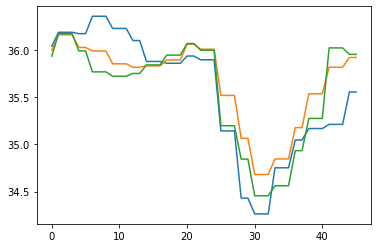

In [12]:
alat = ds.isel(trajectory=0).sel(time='2020-02-18T00').latitude[0]
alon = ds.isel(trajectory=0).sel(time='2020-02-18T00').longitude[0]
print(alat.data,alon.data,ds.isel(trajectory=0).sel(time='2020-02-18T00').SAL_SBE37_MEAN[0].data)
#tem = ds_rss.sel(lat=alat,lon=alon,method='nearest')
#print(tem)
#plt.plot(tem.time,tem.smap_sss)
#plt.plot(tem.time,tem.smap_sss_40km)
print(ds_jpl.lat[25].data,ds_jpl.lon[29].data)
plt.plot(ds_jpl.smap_sss[:,25,29])
plt.plot(ds_rss.sss_smap[:,25,29])
plt.plot(ds_rss.sss_smap_40km[:,25,29])
#tem = ds_jpl.sel(lat=alat,lon=alon)
#plt.plot(tem.time,tem.sss_smap)
#ds_jpl.sel(lat=alat,method='nearest')

# Check what the min/max/mean distance travelled between 1 min obs

In [ ]:
for iusv in range(3):
    print(ds.dist_between[iusv,:].min().data,ds.dist_between[iusv,:].max().data,ds.dist_between[iusv,:].mean().data)
#ave distance is 0.08 km = 80 m 

# Make an evenly sampled timeseries
- Swap the coordinates from time to distance_total
- interp along evenly sampled distance total, 80m (0.08km)

In [ ]:
ds_usv = ds.isel(trajectory=0)
ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
ds3 = ds2.swap_dims({'time':'dist_total'})
dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
ds4 = ds3.interp(dist_total=dist_interp)

In [ ]:
plt.plot(ds2.time,ds3.density_mean)
plt.plot(ds_usv.time,ds_usv.density_mean)


# detrend

In [ ]:
den = ds4.density_mean.interpolate_na(dim='dist_total')
ds4_detrend = signal.detrend(den)

In [ ]:
#plt.plot(ds4.density_mean)
#plt.plot(den)
plt.plot(ds4_detrend)

# , smooth using 2km gaussian filter then power density

In [ ]:
ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
plt.plot(ds4_detrend_smooth[5000:7000])
plt.plot(ds4_detrend[5000:7000])


In [ ]:
f, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
plt.loglog(f[2:5000], Pxx_den[2:5000])
plt.loglog(f[2:5000], f[2:5000]**(-2.4)/100000)
#plt.semilogy(f[2:200], Pxx_den[2:200])
plt.xlabel('frequency [km]')
plt.ylabel('PSD [kg/m^3 /km]')

# okay, now do all the USV

In [ ]:
data_all=[]
for iusv in range(3):
    ds_usv = ds.isel(trajectory=0)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
    ds3 = ds2.swap_dims({'time':'dist_total'})
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
    ds4 = ds3.interp(dist_total=dist_interp)
    den = ds4.density_mean.interpolate_na(dim='dist_total')
    ds4_detrend = signal.detrend(den)
    ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
    f, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
    if iusv==0:
        data_all=ds4_detrend_smooth
        ps_all=Pxx_den[0:10000]
    else:
        data_all = np.concatenate([data_all,ds4_detrend_smooth])
        ps_all = np.vstack([ps_all,Pxx_den[0:10000]])
    print(iusv)
f, Pxx_den = signal.periodogram(data_all[:101000],1/.080)  #fs = sampled at .08km or 80m
plt.loglog(f[5:900], Pxx_den[5:900])
plt.loglog(f[5:900], f[5:900]**(-2.4)/100000)
plt.xlabel('frequency [km]')
plt.ylabel('PSD [kg/m^3 /km]')

In [ ]:
Pxx_den = np.mean(ps_all,axis=0)
#f, Pxx_den = signal.periodogram(data_all[:101000],1/.080)  #fs = sampled at .08km or 80m
plt.loglog(f[5:900], Pxx_den[5:900])
plt.loglog(f[5:900], f[5:900]**(-2.4)/100000)
plt.xlabel('frequency [km]')
plt.ylabel('PSD [kg/m^3 /km]')

In [ ]:
for iusv in range(3):
    len2=0.1
    ds_usv = ds.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
    ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
    ds4 = ds3.interp(dist_total=dist_interp)       
    den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
    print(np.nanmax(den_grad))
    print('dist:',dist_interp.max())

In [ ]:
for iusv in range(3):
    len2=0.1
    ds_usv = ds.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
    ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
    ds4 = ds3.interp(dist_total=dist_interp)       
    den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
    print(np.nanmax(den_grad))
    print('dist:',dist_interp.max())
    plt.plot(den_grad)

In [ ]:
for iusv in range(3):
    len2=0.1
    ds_usv = ds.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
    ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
    ds4 = ds3.interp(dist_total=dist_interp)       
    den_grad =  np.abs(np.gradient(ds4.SAL_SBE37_MEAN)/len2)
    print(np.nanmax(den_grad))
    print('dist:',dist_interp.max())
    plt.plot(den_grad)    
    plt.plot(ds4.SAL_SBE37_MEAN)

In [ ]:
g1=abs(np.gradient(ds2.density_mean))/0.08
g2=abs(np.gradient(ds4.density_mean))/20
r1,x=np.histogram(g1,bins=np.arange(0,0.04,0.001))
r2,x=np.histogram(g2,bins=np.arange(0.,0.04,0.001))
plt.plot(x[:-1],r1/sum(r1),'r')
plt.plot(x[:-1],r2/sum(r2),'b')

In [ ]:
plt.plot(ds2.dist_total,ds2.density_mean,'r')
plt.plot(ds4.dist_total,ds4.density_mean,'b.')

In [ ]:
for iusv in range(3):
    len2=0.1
    ds_usv = ds.isel(trajectory=iusv)
    plt.plot(ds_usv.time,ds_usv.SAL_SBE37_MEAN,label=ds_usv.trajectory.data)
    plt.legend()
    plt.xticks(rotation=45) 
    

In [ ]:
fig = plt.figure(figsize=(8,12))
ax = plt.axes(projection = ccrs.PlateCarree())  # create a set of axes with Mercator projection
for i in range(3):
    ds2 = ds.isel(trajectory=i)
    im=ax.scatter(ds2.longitude,ds2.latitude,c=ds2.SAL_SBE37_MEAN,vmin=34,vmax=36,
                  s=.15,transform=ccrs.PlateCarree(),label=ds2.trajectory.data,cmap='jet')
    ax.coastlines(resolution='10m')                
    ax.set_extent([-64,-46,4,16])
    #ax.legend()
cax = fig.add_axes([0.5, 0.6, 0.3, 0.02])
cbar = fig.colorbar(im,cax=cax, orientation='horizontal')
cbar.set_label('Salinity (psu)')
fig.savefig(figs_dir+'map_sss_nasa.png')    

# make map

In [ ]:
#make arrays for sampling at different length scales

sat_str = 'rss_40km'
data_in = ds_rss
data_in['density_mean']=data_in.sss_smap.copy(deep=True)
for iusv in range(3):   
    tem=sw.dens0(data_in.sss_smap_40km[iusv,:],data_in.surtep[iusv,:]-273.15) #ds.TEMP_SBE37_MEAN[iusv,:])
    data_in['density_mean'][iusv,:]=tem
data_in['dist_total']=ds.dist_total

data_all=[]
for iusv in range(3):
    ds_usv = data_in.isel(trajectory=iusv)
    ds_usv['dist_total']=ds.isel(trajectory=iusv).dist_total
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
    ds3 = ds2.swap_dims({'time':'dist_total'})
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
    ds4 = ds3.interp(dist_total=dist_interp)
    den = ds4.density_mean.interpolate_na(dim='dist_total')
    den = den.where(np.isfinite(den),drop=True)
    ds4_detrend = signal.detrend(den)
    ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
    f, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
    if iusv==0:
        data_all=ds4_detrend_smooth
        ps_all=Pxx_den[0:10000]
    else:
        data_all = np.concatenate([data_all,ds4_detrend_smooth])
        ps_all = np.vstack([ps_all,Pxx_den[0:10000]])
    print(iusv)
f, Pxx_den = signal.periodogram(data_all[:101000],1/.080)  #fs = sampled at .08km or 80m


length_scale = np.arange(.1,100,1)
# create the empty data arrays to store the normalized histograms (normalized the *100 for percentage count)
xx_in = np.arange(0,.04,.001)
xx_in2 = np.arange(0,.04-.001,.001)
data = np.zeros((len(length_scale),len(xx_in2)))
ddn=xr.DataArray(data,dims=('length_scale','gradx'),coords={'length_scale':length_scale,'gradx':xx_in2})
for iusv in range(3):
    ds_usv = data_in.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
    ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
    for ilen2,len2 in enumerate(length_scale):
        dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
        ds4 = ds3.interp(dist_total=dist_interp)       
        den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
        result,xx = np.histogram(den_grad,bins=xx_in)
        ddn[ilen2,:]=ddn[ilen2,:]+result
for ilen2,len2 in enumerate(length_scale):
    ddn[ilen2,:]=ddn[ilen2,:]/sum(ddn[ilen2,:])*100  #normalize & turn into percent
    
print(len(length_scale),len(xx_in))
fig = plt.figure(figsize=(14,10))
tem=ddn
tem = tem.where(tem>.003)
Z=tem.T
ax = plt.pcolormesh(length_scale,xx_in2,Z, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),vmin=.01,vmax=100,cmap='hot')
plt.text(25,0.036,'(a)'+sat_str,fontsize=16,color='k')
plt.xlabel('Length scale (km)',fontsize=16)
plt.ylabel('Density gradient (kg m$^{-3}$ km$^{-1}$)',fontsize=16)
cb = plt.colorbar()
cb.set_label(label='Percent count',fontsize=16)


plt.axes([.43, .57, .3, .3])


#cal PSD
Pxx_den = np.mean(ps_all,axis=0)
#f, Pxx_den = signal.periodogram(Pxx_den,1/.080)  #fs = sampled at .08km or 80m
istart,iend=10,5550
plt.loglog(f[istart:iend], Pxx_den[istart:iend])

#linear regression to PSD
istart,iend=10,1000
XX = np.log(f[istart:iend])
YY = np.log(Pxx_den[istart:iend])
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(f[istart:iend], f[istart:iend]**(a)/np.exp(b),'r') #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(.02,.1,slp_str,fontsize=16,color='r')
plt.ylim([10e-6,10e1])
plt.xlim([10e-4,10e-1])

plt.text(.002,20,'(b)',fontsize=16,color='k')
plt.xlabel('Wavenumber (cpkm)')
plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$)')
plt.grid()
plt.savefig(figs_dir+'PSD_den_grad_sat_'+sat_str+'.png')

In [ ]:
istart,iend=10,32
print(1/f[istart],1/f[iend])

In [ ]:
istart,iend=10,115
print(1/f[istart],1/f[iend])

In [ ]:
ilen2=120
ds_usv = ds.isel(trajectory=0)
ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
ds3 = ds2.swap_dims({'time':'dist_total'})
dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],ilen2)
ds4 = ds3.interp(dist_total=dist_interp)
ds5 = ds4.interp(dist_total=np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08))

In [ ]:
ds3.sel(dist_total=slice(3700,4200)).SAL_SBE37_MEAN.plot()
ds5.sel(dist_total=slice(3700,4200)).SAL_SBE37_MEAN.plot()